In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.stats
from tqdm.notebook import tqdm
from multiprocessing import Pool
from functools import partial
from scipy.stats import multivariate_normal
import random
import matplotlib
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, BatchNormalization, Activation, Add, add, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
#from tensorflow.keras.optimizers.legacy import RMSprop, Adam
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import sys

# Training CNN model
(paper @ https://eprint.iacr.org/2018/053.pdf) \
I trained the CNN. 

In [8]:
# AES sbox
HW = np.array([bin(n).count("1") for n in range(0, 256)])
def read_data(file_loc, raw=False):
    """
    Reads in the ASCAD h5 dataset from the given dir_loc. If raw = False, reads ASCAD.h5 and assumes the simplified dataset structure.
    If raw = True, reads ATMega8515_raw_traces.h5 and assumes the raw traces dataset structure. 
    Returns the tuple: (x_train, x_test, plt_train, plt_test, keys_train, keys_test)
    :dir_loc: directory where the ASCAD dataset is located. Default = 'F:\\ASCAD\\ATMEGA_AES_v1\\ATM_AES_v1_fixed_key\\ASCAD_data\\ASCAD_databases\\'
    :data_name: Dataset name. Default = 'ASCAD.h5'
    """
    with h5py.File(file_loc, "r") as in_file:
        # Load traces
        x_train = np.array(
            in_file['Profiling_traces/traces'], dtype=np.int8)
        x_test = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
        # labels are sbox(plt[2] XOR key[2])
        
        labels_train = np.array(in_file['Profiling_traces/labels'])
        labels_test = np.array(in_file['Attack_traces/labels'])
        
        plt_train = np.array(
            in_file['Profiling_traces/metadata']['plaintext'])
        plt_test = np.array(in_file['Attack_traces/metadata']['plaintext'])

        keys_train = np.array(in_file['Profiling_traces/metadata']['key'])
        keys_test = np.array(in_file['Attack_traces/metadata']['key'])
        
        masks_train = np.array(in_file['Profiling_traces/metadata']['masks'])
        masks_test = np.array(in_file['Attack_traces/metadata']['masks'])
        
        return x_train, x_test, labels_train, labels_test, plt_train, plt_test, keys_train, keys_test, masks_train, masks_test
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
])
def snr(obs_value, traces):
    max_val = np.max(obs_value)
    means = [None] * (max_val + 1)
    varss = [None] * (max_val + 1)
    for i in range(max_val + 1):
        means[i] = np.mean(traces[obs_value == i], axis=0)
        varss[i] = np.var(traces[obs_value == i], axis=0)
    means = np.array(means)
    varss = np.array(varss)
    snr = np.zeros_like(means[0])
    u_tot = np.mean(means, axis=0)
    v_tot = np.mean(varss, axis=0)
    for i in range(max_val + 1):
        snr += np.power(means[i]-u_tot, 2)
    snr = snr / v_tot
    return snr
def partial_key(key_guess, attack_byte, pt, traces): # ^ = XOR
    # xoring plaintext with key guess
    hypotheses = np.array([HW[sbox[pt[i, attack_byte] ^ key_guess]] for i in range(pt.shape[0])])
    # we use the hypotheses and calculate the correlation
    
    return np.max(np.corrcoef(hypotheses, traces, rowvar=False)[0, 1:])
def random_subset(size, *a):
    """
    Takes a random subset of size :size: from the given arrays. Makes sure that the rows of the arrays still match after shuffling.
    Example usage: subset_train, subset_labels = random_subset(10, training_set, training_labels)

    :size: size of the subset
    :*a: arrays to take subset of
    """
    combined = list(zip(*a))
    random.shuffle(combined)
    b = [np.array(i)[:size] for i in zip(*combined)]

    return b

def ge_sr(traces, plaintext, key, byte, model, success_cutoff, nr_attack_traces, averaging_nr, track=False, data_augment=None):
    """
    Returns (guessing entropy, success rate) tuple of the given model over the given traces

    :traces: all available attacking traces
    :plaintext: all corresponding plaintext
    :key: the real key
    :byte: byte of key to attack
    :model: model used for making predictions
    :success_cutoff: cutoff to calculate success rate (key rank < success_cutoff)
    :nr_attack_traces: number of traces to use for attacking
    :averaging_nr: number of times to perform attack on subtraces in order to calculate the guessing entropy and success rate
    :track: boolean to indicate whether the guessing entropy should be tracked for each trace amount up to :nr_attack_traces:
    :data_augment: Default None. If not None, should be a function which takes traces as input and returns the augmented traces.
    """

    if track:
        key_ranks = np.zeros((averaging_nr, nr_attack_traces))
        successes = np.zeros((averaging_nr, nr_attack_traces))
    else:
        key_ranks = np.zeros((averaging_nr))
        successes = np.zeros((averaging_nr))

    for run in tqdm(range(averaging_nr), desc="run", leave=False):
        # take a random subset from the attacking traces
        attack_traces, attack_plaintext = random_subset(
            nr_attack_traces, traces, plaintext)

        if data_augment:
            print(f"applying data augmentation")
            attack_traces = data_augment(attack_traces)
        
        # make predictions: probability of each label, where label = sbox[plt[byte] ^ key[byte]]
        predictions = model(attack_traces, training=False)

        # convert probability to log values
        predictions = np.log(predictions+1e-20)
        _, leakage_mdl = predictions.shape
            
        # set the key probabilities to 0 for each key hypothesis
        key_probabilities = np.zeros(256)

        # for each trace, add up the log(probability) of each key hypothesis
        for i in tqdm(range(nr_attack_traces), desc='attack', leave=False):
            for k in range(256):
                if leakage_mdl == 9:
                    key_probabilities[k] += predictions[i, HW[sbox[attack_plaintext[i, byte] ^ k]]]
                else:
                    key_probabilities[k] += predictions[i, sbox[attack_plaintext[i, byte] ^ k]]

            # if tracking per trace, then add to key_ranks and successes array here
            if track:
                # now key_probabilities contains estimated key probability after i traces
                key_rank = list(np.argsort(key_probabilities)
                                [::-1]).index(key[byte])
                success = int(key_rank < success_cutoff)

                key_ranks[run, i] = key_rank
                successes[run, i] = success

        # if not tracking per trace, only add to key_ranks and successes array after all traces are attacked
        if not track:
            # now key_probabilities contains the estimated key probability of each key after the full attack
            # argsort()[::-1] -> sorts key values from most likely to least likely. Then get index of actual key byte to get the key rank.
            key_rank = list(np.argsort(key_probabilities)
                            [::-1]).index(key[byte])

            success = int(key_rank < success_cutoff)

            key_ranks[run] = key_rank
            successes[run] = success

    return np.mean(key_ranks, axis=0), np.mean(successes, axis=0)

In [9]:

x_train, x_test, labels_train, labels_test, plt_train, plt_test, keys_train, keys_test, masks_train, masks_test = read_data('Base_desync0.h5')

In [38]:

class myCNN:
    
    def __init__(self, name="CNN"):
        self.name = name
        
    def cnn_best(self, classes=256,input_dim=700):
        # From VGG16 design
        input_shape = (input_dim,1)
        img_input = Input(shape=input_shape)
        # Block 1
        x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(img_input)
        x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
        # Block 2
        x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
        x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
        # Block 3
        x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
        x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
        # Block 4
        #x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
        #x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
        # Block 5
        #x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
        #x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(128, activation='relu', name='fc1')(x)
        x = Dropout(0.2)(x) 
        #x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    

        inputs = img_input
        # Create model.
        model = Model(inputs, x, name='cnn_best')
        optimizer = RMSprop(lr=0.00001)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model
    

def train_model(X_profiling, Y_profiling, model, save_file_name, epochs=150, batch_size=100, multilabel=0, validation_split=0, early_stopping=0):
    #check_file_exists(os.path.dirname(save_file_name))
    # Save model calllback
    save_model = ModelCheckpoint(save_file_name)
    callbacks=[save_model]
    # Early stopping callback
    if (early_stopping != 0):
        if validation_split == 0:
            validation_split=0.1
        callbacks.append(EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True))
    # Get the input layer shape
    if isinstance(model.get_layer(index=0).input_shape, list):
        input_layer_shape = model.get_layer(index=0).input_shape[0]
    else:
        input_layer_shape = model.get_layer(index=0).input_shape
    # Sanity check
    if input_layer_shape[1] != len(X_profiling[0]):
        print("Error: model input shape %d instead of %d is not expected ..." % (input_layer_shape[1], len(X_profiling[0])))
        sys.exit(-1)
    # Adapt the data shape according our model input
    if len(input_layer_shape) == 2:
        # This is a MLP
        Reshaped_X_profiling = X_profiling
    elif len(input_layer_shape) == 3:
        # This is a CNN: expand the dimensions
        Reshaped_X_profiling = X_profiling.reshape((X_profiling.shape[0], X_profiling.shape[1], 1))
    else:
        print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
        sys.exit(-1)
    #print(f"shape Reshaped X: {Reshaped_X_profiling.shape}")
    y=to_categorical(Y_profiling, num_classes=256)
    #y = tf.keras.utils.to_categorical(Y_profiling, num_classes=256)
    
    history = model.fit(x=Reshaped_X_profiling, y=y, batch_size=batch_size, verbose = 1, validation_split=validation_split, epochs=epochs, callbacks=callbacks)
    return history

In [39]:
#from sklearn.decomposition import PCA
#pca =PCA(n_components=100)
#X_train = pca.fit_transform(x_train)
CNN = myCNN().cnn_best(input_dim=700, classes=256)
CNN.summary()

Model: "cnn_best"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 700, 1)]          0         
                                                                 
 block1_conv1 (Conv1D)       (None, 700, 64)           768       
                                                                 
 block1_pool (AveragePoolin  (None, 350, 64)           0         
 g1D)                                                            
                                                                 
 block2_conv1 (Conv1D)       (None, 350, 128)          90240     
                                                                 
 block2_pool (AveragePoolin  (None, 175, 128)          0         
 g1D)                                                            
                                                                 
 block3_conv1 (Conv1D)       (None, 175, 256)          360

In [40]:

print(tf.config.list_physical_devices('GPU'))

#print(labels_train.shape)
#print(keys_train.shape)
#print(keys_train)
with tf.device('GPU'):
    history = train_model(x_train, labels_train, CNN, "cnn", batch_size=64, epochs=30, validation_split=0.1, early_stopping=1)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/30


2023-06-04 21:06:41.778795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 5.6353 - accuracy: 0.0035

2023-06-04 21:07:21.897492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


704/704 [==============================] - 43s 59ms/step - loss: 5.6353 - accuracy: 0.0035 - val_loss: 5.5450 - val_accuracy: 0.0038
Epoch 2/30
703/704 [============================>.] - ETA: 0s - loss: 5.5441 - accuracy: 0.0045INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


704/704 [==============================] - 42s 59ms/step - loss: 5.5441 - accuracy: 0.0045 - val_loss: 5.5453 - val_accuracy: 0.0044
Epoch 3/30
703/704 [============================>.] - ETA: 0s - loss: 5.5435 - accuracy: 0.0049INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


704/704 [==============================] - 42s 59ms/step - loss: 5.5435 - accuracy: 0.0049 - val_loss: 5.5457 - val_accuracy: 0.0044
Epoch 4/30
703/704 [============================>.] - ETA: 0s - loss: 5.5432 - accuracy: 0.0043INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


704/704 [==============================] - 41s 58ms/step - loss: 5.5432 - accuracy: 0.0043 - val_loss: 5.5460 - val_accuracy: 0.0038
Epoch 5/30
703/704 [============================>.] - ETA: 0s - loss: 5.5432 - accuracy: 0.0045INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


704/704 [==============================] - 42s 59ms/step - loss: 5.5431 - accuracy: 0.0045 - val_loss: 5.5462 - val_accuracy: 0.0038
Epoch 6/30
703/704 [============================>.] - ETA: 0s - loss: 5.5431 - accuracy: 0.0049INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


704/704 [==============================] - 42s 59ms/step - loss: 5.5431 - accuracy: 0.0049 - val_loss: 5.5463 - val_accuracy: 0.0044
Epoch 7/30
703/704 [============================>.] - ETA: 0s - loss: 5.5431 - accuracy: 0.0045INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


704/704 [==============================] - 42s 59ms/step - loss: 5.5431 - accuracy: 0.0045 - val_loss: 5.5467 - val_accuracy: 0.0044
Epoch 8/30
703/704 [============================>.] - ETA: 0s - loss: 5.5431 - accuracy: 0.0048INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


704/704 [==============================] - 42s 59ms/step - loss: 5.5431 - accuracy: 0.0048 - val_loss: 5.5469 - val_accuracy: 0.0044
Epoch 9/30
703/704 [============================>.] - ETA: 0s - loss: 5.5431 - accuracy: 0.0048INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


704/704 [==============================] - 41s 59ms/step - loss: 5.5431 - accuracy: 0.0048 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 10/30
703/704 [============================>.] - ETA: 0s - loss: 5.5431 - accuracy: 0.0047INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


704/704 [==============================] - 41s 59ms/step - loss: 5.5431 - accuracy: 0.0047 - val_loss: 5.5470 - val_accuracy: 0.0044
Epoch 11/30
703/704 [============================>.] - ETA: 0s - loss: 5.5431 - accuracy: 0.0046INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


704/704 [==============================] - 42s 60ms/step - loss: 5.5431 - accuracy: 0.0046 - val_loss: 5.5470 - val_accuracy: 0.0038


In [41]:
#X_test = pca.transform(x_test)
predictions = CNN.predict(x_test)
predictions = np.log(predictions + 1e-20)

 14/313 [>.............................] - ETA: 2s

2023-06-04 21:18:31.684299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 9ms/step


In [42]:
import itertools
key_vector = np.zeros(256)
attack_byte = 2
for i, kguess in itertools.product((range(10)), range(256)):
    hypothesis = sbox[plt_test[i, attack_byte] ^ kguess]
    key_vector[kguess] += predictions[i, hypothesis]
print(np.argsort(key_vector))
index = len(key_vector) - np.where(np.argsort(key_vector)==keys_test[0][attack_byte])[0][0]
print(f"position of the key {index} over {len(key_vector)} positions")
print(f"key hypothesis with highest log-likelihood: {np.argmax(key_vector)}, correct key: {keys_test[0][attack_byte]}")

[ 70 144 246   1 207 175   9   5 143  32 223 163 139  31 195 156 121 180
  21 176  34  38 115 185 125 167   8 113 119 181  40  58 140 101 215 240
  85 191 252  54 152 172  60 124 130 123 203  14 239 122  35 171  77  86
 219  12 201  11 120 235 236  97 103 177  44 128  23  36 127 105 248 196
 232  27 244 224  69 142 150  20  90 126 254 233 213 245   0  63  55 202
  62  88 184 111  42 204 255 251 110 208  74  72  15 234   7 118   6  19
 170  76 237 243 134  64 183  81 193  84 200  49  26  99 247 148 155 169
  33  71  92 199  13 226 209  46 217 222 164  66  50 188 189 228 131 231
 192 249 206 173 132 136 146  94 182   3 194 159 197 104 114 133 153  28
 242  78  75  25  83  68 117  56  51 135 211  95 157 138 214  87 116 221
 129  18  24 106 168 198  80  30  45  43  10 179 216 166  96 178 210  91
 230 218  65  37 162 187  48  82  59  98 165  61 190 253 100  17 225   4
 147 250  29 112 102 212 205  22 109  67 141 158 145 149 108  47  79 107
 229  89 137 238 174  73 160 186  41  52  16 151 24

In [43]:
ge, sr=ge_sr(x_test, plt_test, keys_test[0], attack_byte, CNN,success_cutoff=1,nr_attack_traces=10,averaging_nr=100, track=True)


run:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

[]

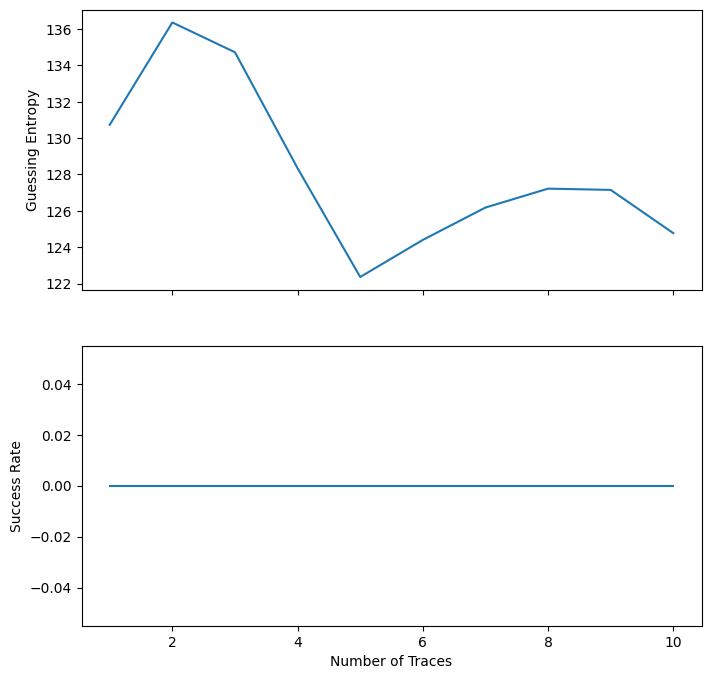

In [44]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
axs[0].plot(range(1, len(ge)+1), ge)
axs[0].set_ylabel("Guessing Entropy")
axs[1].plot(range(1, len(sr)+1), sr)
axs[1].set_ylabel("Success Rate")
axs[1].set_xlabel("Number of Traces")

plt.plot()